In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
train = pd.read_csv('/content/train_kdd_nsl.csv')
test = pd.read_csv('/content/test_kdd_nsl.csv')

In [3]:
train = train.drop_duplicates()
train = train.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [4]:
test = test.drop_duplicates()
test = test.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [5]:
train = train.loc[(train["connection_type"] == 'normal')|(train["connection_type"] == 'satan')]
test = test.loc[(test["connection_type"] == 'normal')|(test["connection_type"] == 'satan')]

In [6]:
train = train.reset_index(drop = True)   #reset index for the train data
test = test.reset_index(drop = True)     #reset index for the test data

In [7]:
train['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in train['protocole_type']]
train['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in train['flag']]

In [8]:
test['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in test['protocole_type']]
test['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in test['flag']]

In [9]:
#This function is used to encode a vector as follows:
'''
when the vector element == 'normal', it will be transformed to 1 and to 0 if not
'''
def encoding(y):
  enc = [1 if y[i]=='normal' else 0 for i in range(len(y))]
  return pd.DataFrame(enc)

In [10]:
y_train = train['connection_type']
y_test = test['connection_type']

In [11]:
y_train = np.array(encoding(y_train))
y_test = np.array(encoding(y_test))

In [12]:
train = train.drop(['connection_type'],axis=1)
test = test.drop(['connection_type'],axis=1)

In [13]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [14]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

##**Parameter Estimaion**

In [15]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_bl(row,theta):
  alpha_K, alpha, beta = theta[:len(theta)-2], theta[len(theta)-2], theta[len(theta)-1]
  c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
  q1 = (alpha-np.sum(alpha_K))*np.log(np.mean(row)) + (beta-1)*np.log(np.abs(1-np.mean(row)))
  q2 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
  return c+q1+q2

In [16]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [17]:
def calcul_inv_hess_vect(data,theta):
  alpha = theta[:len(theta)-2]
  (N, K) = data.shape
  q = N*float(polygamma(1,np.sum(alpha)))
  inv_S = np.diag([-N/np.clip(float(polygamma(1,alpha[m])),10**(-7),None) for m in range(K)])
  a = np.ones(K).reshape(-1,1)
  inv_hess = inv_S + np.dot(np.dot(inv_S,a),np.dot(np.transpose(a),inv_S))/((1/q)*np.dot(np.dot(np.transpose(a),inv_S),a))
  return inv_hess

In [18]:
def calcul_inv_hess_non_vect(data,theta):
  (N,K) = data.shape
  H = np.zeros((2,2))
  alpha, beta = theta[len(theta)-2], theta[len(theta)-1]
  H[0][0] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,alpha)))
  H[1][1] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,beta)))
  H[0][1] = H[1][0] = N*float(polygamma(1,alpha+beta))
  inv_H = np.linalg.inv(H)
  return inv_H

In [19]:
def derivative(data,theta_old):
  (N, K) = data.shape
  der_vect_alpha = np.zeros(K)
  vect_alpha_old, alpha_old, beta_old = theta_old[:len(theta_old)-2], theta_old[len(theta_old)-2], theta_old[len(theta_old)-1]
  for s in range(K):
    der_vect_alpha[s] =N*(psi(np.sum(vect_alpha_old)) - psi(vect_alpha_old[s])) - np.sum( np.log(data[:,s]) )
  der_alpha = N*(psi(alpha_old+beta_old)-psi(alpha_old)) + np.sum([np.log(np.mean(data[i])) for i in range(N)])
  der_beta = N*(psi(alpha_old+beta_old)-psi(alpha_old)) + np.sum([np.log(1-np.mean(data[i])) for i in range(N)])
  der_theta = np.concatenate((der_vect_alpha, der_alpha,der_beta), axis=None)
  return der_theta

In [20]:
def update_theta(data,theta_old):
  inv_hess_vect = calcul_inv_hess_vect(data,theta_old)
  inv_hess_non_vect = calcul_inv_hess_non_vect(data,theta_old)
  der_param = derivative(data,theta_old)

  vect_alpha_old, alpha_beta_old = theta_old[:len(theta_old)-2], theta_old[len(theta_old)-2:]
  der_vect_alpha_old, der_alpha_beta_old = der_param[:len(der_param)-2], der_param[len(der_param)-2:]

  vect_alpha_new = vect_alpha_old - np.dot(inv_hess_vect,der_vect_alpha_old)
  vect_alpha_new = normalize_theta(vect_alpha_new,0.1,2)
  alpha_beta_new = alpha_beta_old - np.dot(inv_hess_non_vect,der_alpha_beta_old)
  alpha_beta_new = normalize_theta(alpha_beta_new,0.1,2)
  theta_new = (np.clip(np.concatenate((vect_alpha_new,alpha_beta_new), axis=None),10**(-15),None))

  return theta_new

In [21]:
theta_zero =  [2.78918617, 3.6044279,  3.05354054, 2.7699276,  2.17590852, 3.26488115,
 2.24417734, 4.4696877,  4.82194753, 1.97886344, 3.97945269, 2.69158511,
 2.88341835, 4.63542353, 0.44807669, 0.52693357, 0.19907015, 4.17983724,
 3.91296808, 4.36305953, 4.89522988, 4.01587696, 2.36124888, 3.92459296,
 0.67954469, 3.235613,   0.80243111, 4.72887769, 2.65705678]

In [22]:
'''#theta_zero = np.concatenate((moment_initialization(train),np.random.uniform(low=0.1, high=1, size=(3,))), axis=None)
theta_zero = np.random.uniform(low=0.1, high=5, size=(train.shape[1]+2,))
print('theta_zero = ',np.array(theta_zero))'''
theta_old = theta_zero

In [23]:
max_iter = 5
for j in range(max_iter):
  theta_new = update_theta(train,theta_old)
  theta_old = theta_new

##**Feature mapping**

In [24]:
train_df = pd.DataFrame(train)
#train_df['new_feature'] = normalize_theta([log_bl(row,theta_new) for row in train],130,150)
train_df['new_feature'] = [log_bl(row,theta_new) for row in train]

test_df = pd.DataFrame(test)
#test_df['new_feature'] = normalize_theta([log_bl(row,theta_new) for row in test],130,150)
test_df['new_feature'] = [log_bl(row,theta_new) for row in test]

In [25]:
train_f = np.array(train_df)
test_f = np.array(test_df)

In [26]:
from sklearn.svm import SVC
# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(kernel='rbf', C=20, gamma='auto', random_state=42)
svm.fit(train_f, np.ravel(y_train))

Training SVM classifier...


SVC(C=20, gamma='auto', random_state=42)

In [27]:
# Test SVM classifier
print("Testing SVM classifier...")
y_pred_svm = svm.predict(test_f)

Testing SVM classifier...


In [28]:
def re_encoding(y):
  enc = [0 if y[i]==1 else 1 for i in range(len(y))]
  return pd.DataFrame(enc)

In [29]:
y_tesst = np.array(re_encoding(y_test))
y_pred_svm = np.array(re_encoding(y_pred_svm))

In [30]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics
# Evaluate the performance of the classifier
print("F1 Score:", f1_score(y_tesst, y_pred_svm))
print("Precision:", precision_score(y_tesst, y_pred_svm))
print("Recall:", recall_score(y_tesst, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_tesst, y_pred_svm))
print("Accuracy:", accuracy_score(y_tesst, y_pred_svm))

F1 Score: 0.8508655126498003
Precision: 0.833116036505867
Recall: 0.8693877551020408
Confusion Matrix:
 [[9583  128]
 [  96  639]]
Accuracy: 0.9785563852192227


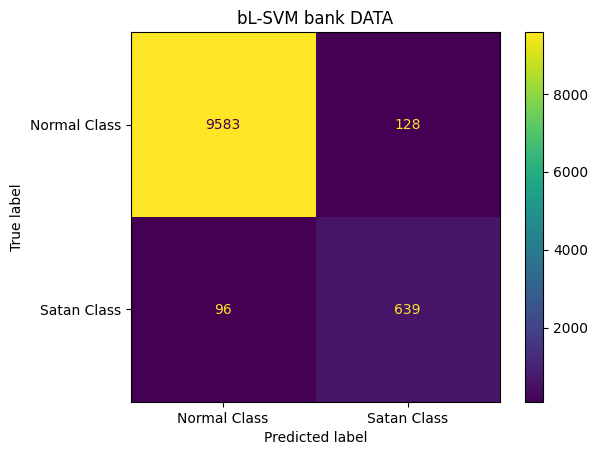

In [31]:
cm = confusion_matrix(y_tesst, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Normal Class', 'Satan Class'])
cm_display.plot()
cm_display.ax_.set_title('bL-SVM bank DATA')
plt.show()